In [882]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

## Calculating Wind Veer and Shear

In [885]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    
    return diff

def calculate_wind_veer_and_shear(file_paths, start_date=None, end_date=None):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
        start_date (datetime): Optional start date as a datetime object.
        end_date (datetime): Optional end date as a datetime object.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []
    all_wind_shear = []

    # Convert start_date and end_date to UTC (if need be)
    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        # Load netCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values  # Quality control variable for wind speed
        azim = ds['Azim'].values  # Wind direction (vector-averaged) in degrees
        qc_azim = ds['qc_Azim'].values  # Quality control variable for wind direction
        
        times = pd.to_datetime(time_var.values, utc=True)  # Convert to datetime
        
        # Filter by date range if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
            azim = azim[valid_idx, :]
            qc_azim = qc_azim[valid_idx, :]

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        # Calculate wind veer (difference in wind direction between 140m and 40m)
        wind_direction_40m = azim[:, idx_40m]  # Wind direction at 40m
        wind_direction_140m = azim[:, idx_140m]  # Wind direction at 140m

        
        # Calculate wind shear (difference in wind speed with height, normalized over vertical distance)
        height_diff = height_var[idx_140m] - height_var[idx_40m]  # Vertical distance between 40m and 140m
        wind_speed_40m = vhm[:, idx_40m]  # Wind speed at 40m
        wind_speed_140m = vhm[:, idx_140m]  # Wind speed at 140m
        
        # Wind shear is calculated as the difference in wind speeds normalized by the vertical height difference
        wind_shear = (wind_speed_140m - wind_speed_40m) / height_diff

        # Compute wind veer as the shortest rotational path between the two heights
        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        wind_veer =  difference / height_diff
        
        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]
        wind_shear = wind_shear[valid_mask]

        # Append data to lists
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)
        all_wind_shear.extend(wind_shear)

    return all_times, all_wind_veer, all_wind_shear

## Wind Shear using Power Law

In [888]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    """
    Calculate the power law exponent (alpha) between two wind speeds at two heights.

    Parameters:
        v1 (array-like): Wind speed at the first height.
        v2 (array-like): Wind speed at the second height.
        z1 (float): The height for v1.
        z2 (float): The height for v2.

    Returns:
        float: The power law exponent alpha.
    """
    # Ensure v1, v2, z1, z2 are positive
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    
    # Ensure z2 > z1 to avoid invalid exponentiation
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")

    # Calculate the power law exponent
    alpha = np.log(v2 / v1) / np.log(z2 / z1)
    
    return alpha

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    """
    Calculate wind veer, directional wind shear, and speed shear (with alpha) from netCDF files.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
        start_date (datetime): Optional start date as a datetime object.
        end_date (datetime): Optional end date as a datetime object.
    
    Returns:
        tuple: Times (datetime objects), wind shear values.
    """
    all_times = []
    all_wind_shear = []

    # Convert start_date and end_date to UTC if they are provided
    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        # Load netCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values  # Quality control variable for wind speed
        azim = ds['Azim'].values  # Wind direction (vector-averaged) in degrees
        qc_azim = ds['qc_Azim'].values  # Quality control variable for wind direction
        
        # Assuming the 'time' variable is in seconds since a reference date (e.g., Unix epoch)
        times = pd.to_datetime(time_var.values, utc=True)  # Convert to datetime
        
        # Filter by date range if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
            azim = azim[valid_idx, :]
            qc_azim = qc_azim[valid_idx, :]

        # Ensure height indices for 40m and 140m are correct
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        # Now safely access the indices
        idx_40m = idx_40m[0]
        idx_140m = idx_140m[0]
        
        # Extract wind speed data for 40m and 140m
        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        # Calculate wind veer (difference in wind direction between 140m and 40m)
        wind_direction_40m = azim[:, idx_40m]
        wind_direction_140m = azim[:, idx_140m]
        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        wind_veer = difference / (height_var[idx_140m] - height_var[idx_40m])
        
        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]
        
        # Calculate speed shear using the power law expression
        # Compute the power law exponent (alpha) based on wind speeds at 40m and 140m
        alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, height_var[idx_40m], height_var[idx_140m])
        
        # Calculate the speed shear using the calculated alpha
        wind_shear = (wind_speed_140m / wind_speed_40m) ** alpha

        # Append results
        all_times.extend(times)
        all_wind_shear.extend(wind_shear)

    return all_times, all_wind_shear



### Wind Veer Plotting 

In [891]:
def plot_wind_veer(times, wind_veer):
    """
    Plot wind veer over time.
    
    Parameters:
        times (list): List of datetime objects.
        wind_veer (list): List of wind veer values.
    """
    # Debugging: Check the data before plotting
    if len(times) == 0 or len(wind_veer) == 0:
        print("Error: No data to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(times, wind_veer, label="Wind Veer (140m - 40m)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Wind Veer (m/s)")
    plt.title("Wind Veer Over Time")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

## File Collection

In [894]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        #below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        #below is for site C1A
        if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]

# Usage for Site A2
#directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA2'
#Usage for Site C1a
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'

start_date = '20230701'  # Replace with any start date
end_date = '20230731'    # Replace with any end date

matching_files = filter_files_by_date(directory, start_date, end_date)
#print("Matching files:")
#for file_path in matching_files:
#    print(file_path)

### Set Times Below - run each time choose new time frame

In [897]:
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 7, 31)
times, wind_veer, wind_shear = calculate_wind_veer_and_shear(matching_files, start_date=start_date, end_date=end_date)

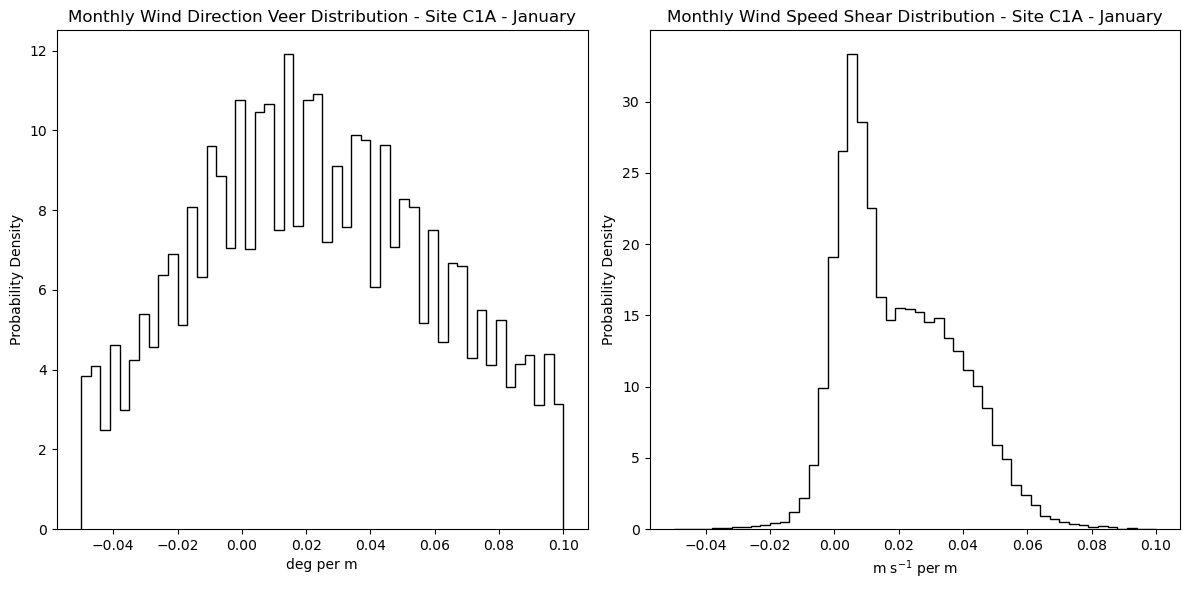

In [899]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', range=[-0.05, 0.1], histtype='step', density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Monthly Wind Direction Veer Distribution - Site C1A - January')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', range=[-0.05, 0.1], histtype='step', density=True)
axs[1].set_xlabel('m s$^{-1}$ per m')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Monthly Wind Speed Shear Distribution - Site C1A - January')

# Show the plot
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


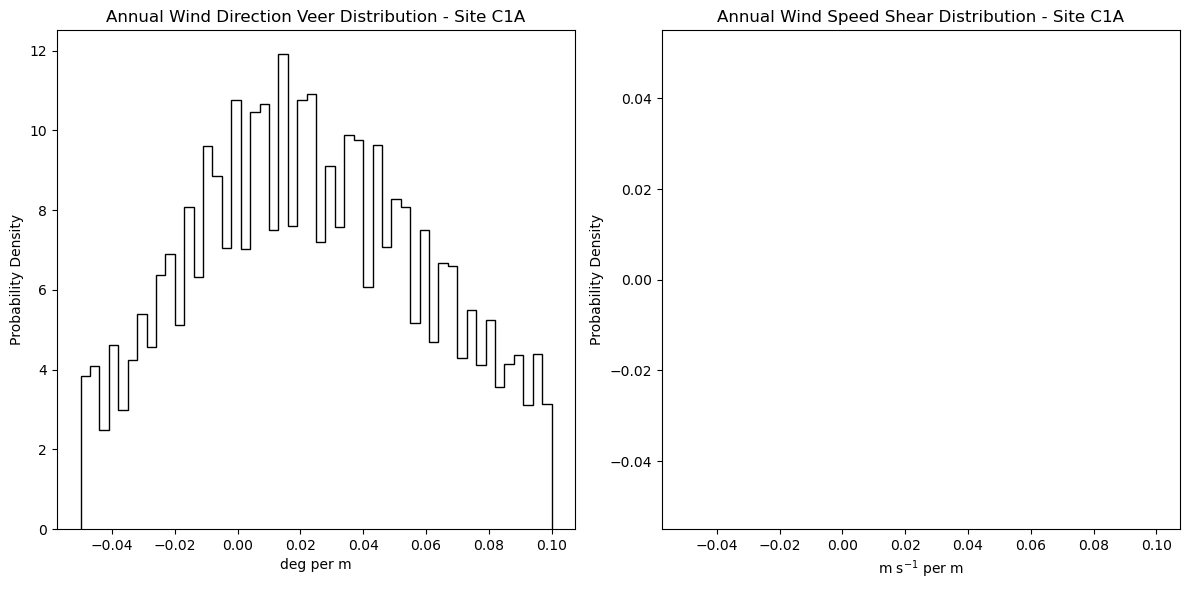

In [901]:
#Power Law Calculation Wind Shear - TODO : DEBUG


start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 7, 31)

times, wind_shear_a = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', range=[-0.05, 0.1], histtype='step', density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Direction Veer Distribution - Site C1A')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear_a, bins=20, edgecolor='black', range=[-0.05, 0.1], histtype='step', density=True)
axs[1].set_xlabel('m s$^{-1}$ per m')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Speed Shear Distribution - Site C1A')

# Show the plot
plt.tight_layout()
plt.show()


Localizing times to UTC...
Converting start_date (2023-07-01 00:00:00) and end_date (2023-07-31 00:00:00) to datetime...
Creating DataFrame with time, wind_veer, and wind_shear...
Creating a complete index for all times of day...
Daily average wind veer (sample):
 00:00    0.007240
01:00   -0.001429
02:00    0.020034
03:00    0.060207
04:00    0.058900
Name: wind_veer, dtype: float64
Daily average wind shear (sample):
 00:00    0.011060
01:00    0.017114
02:00    0.025145
03:00    0.031079
04:00    0.032153
Name: wind_shear, dtype: float64


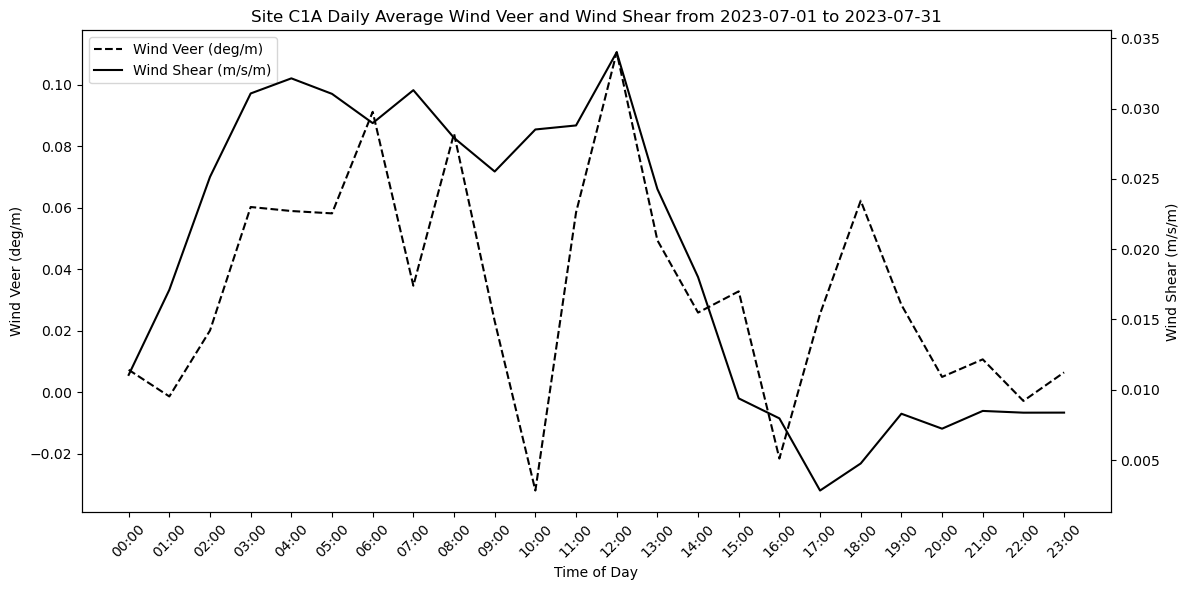

In [903]:
def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC).
    """
    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        print("Localizing times to UTC...")
        times = times.tz_localize('UTC')

    print(f"Converting start_date ({start_date}) and end_date ({end_date}) to datetime...")
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    print("Creating DataFrame with time, wind_veer, and wind_shear...")
    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    print("Creating a complete index for all times of day...")
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping averages together
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].mean().reindex(all_times, fill_value=np.nan)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].mean().reindex(all_times, fill_value=np.nan)
    print("Daily average wind veer (sample):\n", daily_avg_veer.head())
    print("Daily average wind shear (sample):\n", daily_avg_shear.head())

    fig, ax1 = plt.subplots(figsize=(12, 6))

    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='black', linestyle='--', label='Wind Veer (deg/m)'
    )
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    shear_line, = ax2.plot(
        daily_avg_shear.index, daily_avg_shear.values, 
        color='black', linestyle='-', label='Wind Shear (m/s/m)'
    )
    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    ax1.set_xticks(np.linspace(0, len(all_times) - 1, 24))  # 24 evenly spaced ticks for hours
    ax1.set_xticklabels([all_times[i] for i in np.linspace(0, len(all_times) - 1, 24, dtype=int)], rotation=45)

    ax1.set_title(f'Site C1A Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}')

    # Add legend
    lines = [veer_line, shear_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')

    fig.tight_layout()
    plt.show()

# Example usage
# Provide test inputs to see debug output
# times, wind_veer, wind_shear, start_date, end_date need to be defined for this.


# Example usage:
formatted_times = [t.strftime('%Y-%m-%d %H:%M') for t in times]

plotDailyAvgWindShearVeer(formatted_times, wind_veer, wind_shear, start_date, end_date)


Start date: 2023-01-01 00:00:00


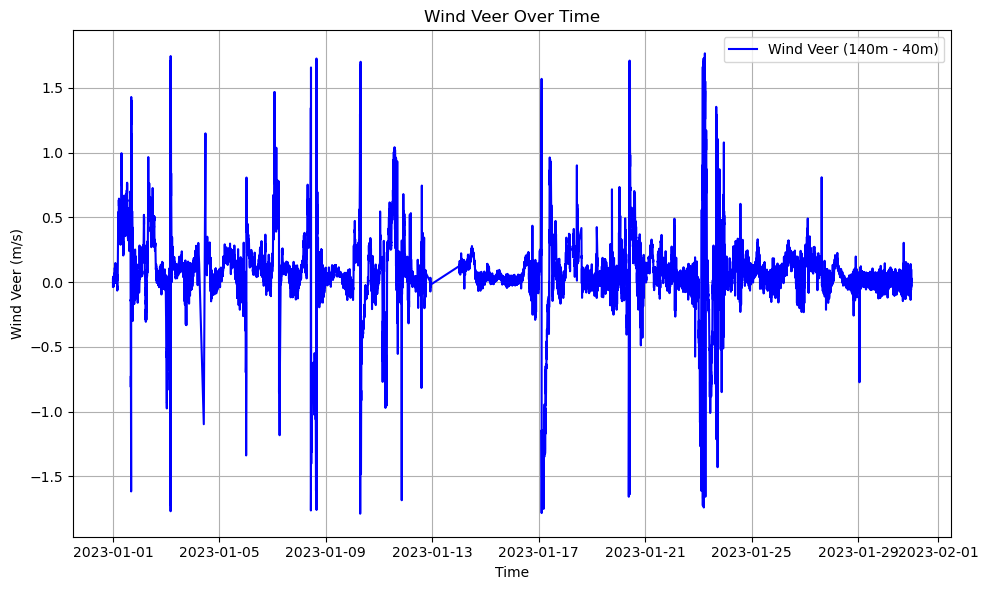

First few times: [Timestamp('2023-01-01 00:02:00+0000', tz='UTC'), Timestamp('2023-01-01 00:04:00+0000', tz='UTC'), Timestamp('2023-01-01 00:06:00+0000', tz='UTC'), Timestamp('2023-01-01 00:08:00+0000', tz='UTC'), Timestamp('2023-01-01 00:10:00+0000', tz='UTC')]
First few wind_veer values: [-0.03399999999999977, 0.03, -0.014000000000000058, -0.035, -0.021999999999999888]


In [874]:
#test plot

start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 1, 31)


print(f"Start date: {start_date}")
#print(f"First time after filtering: {times[0]}")

times, wind_veer, wind_shear = calculate_wind_veer_and_shear(matching_files, start_date=start_date, end_date=end_date)
plot_wind_veer(times, wind_veer)

print(f"First few times: {times[:5]}")
print(f"First few wind_veer values: {wind_veer[:5]}")
